<a href="https://colab.research.google.com/github/madhulathagudimella/urbanHeatrisk-CoolingAccessProject/blob/main/Urban_Heat_Risk_%26_Cooling_Access_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point, Polygon

2. Create Synthetic City Grid (neighborhoods)

In [ ]:
# Example: 5x5 grid = 25 neighborhoods
grid_size = 5
neighborhoods = []
for i in range(grid_size):
    for j in range(grid_size):
        # create square polygons for neighborhoods
        poly = Polygon([
            (i, j), (i+1, j), (i+1, j+1), (i, j+1)
        ])
        neighborhoods.append(poly)

gdf = gpd.GeoDataFrame({
    "neighborhood": [f"N{i}" for i in range(len(neighborhoods))],
    "temperature": np.random.uniform(30, 42, len(neighborhoods)),   # °C
    "humidity": np.random.uniform(40, 90, len(neighborhoods)),      # %
    "tree_canopy": np.random.uniform(0.1, 0.6, len(neighborhoods)), # proportion
    "building_density": np.random.uniform(0.5, 1.5, len(neighborhoods)),
    "svi": np.random.uniform(0, 1, len(neighborhoods)),             # Social Vulnerability Index
}, geometry=neighborhoods)

3. Create Cooling Centers Dataset

In [ ]:
cooling_centers = gpd.GeoDataFrame({
    "name": [f"Center_{i}" for i in range(6)],
    "capacity": np.random.randint(50, 300, 6),
    "geometry": [Point(np.random.uniform(0, grid_size),
                       np.random.uniform(0, grid_size)) for _ in range(6)]
}, crs="EPSG:4326")

 4. Heat Risk Calculation

In [ ]:
# Simple heat index formula (scaled)
gdf["heat_index"] = (gdf["temperature"] * (1 + gdf["humidity"]/100)) / 2
# Heat Risk Score (higher = worse)
gdf["heat_risk"] = (
    gdf["heat_index"] * gdf["building_density"] * (1 - gdf["tree_canopy"])
)

 5. Distance to Cooling Centers

In [ ]:
gdf["dist_to_cooling"] = gdf.geometry.apply(
    lambda x: cooling_centers.distance(x.centroid).min()
)

/tmp/ipython-input-1169451735.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lambda x: cooling_centers.distance(x.centroid).min()


6. Combine with SVI → Final Risk

In [ ]:
gdf["final_risk"] = (
    gdf["heat_risk"] * (1 + gdf["svi"]) * (1 + gdf["dist_to_cooling"]/5)
)

7. Visualization (Static Heatmap)

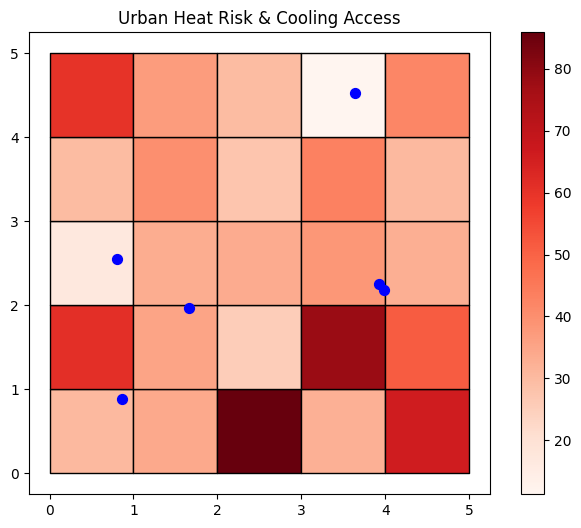

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf.plot(column="final_risk", ax=ax, legend=True, cmap="Reds", edgecolor="black")
cooling_centers.plot(ax=ax, color="blue", markersize=50)
plt.title("Urban Heat Risk & Cooling Access")
plt.show()

8. Interactive Map (Folium)

In [ ]:
m = folium.Map(location=[2.5, 2.5], zoom_start=12)

# Neighborhoods colored by risk
for _, row in gdf.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda feature, risk=row["final_risk"]: {
            "fillColor": "red" if risk > gdf["final_risk"].quantile(0.75) else "green",
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"{row['neighborhood']} | Risk: {row['final_risk']:.2f}"
    ).add_to(m)

# Cooling centers
for _, row in cooling_centers.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"{row['name']} | Capacity: {row['capacity']}"
    ).add_to(m)
m

 9. Identify High-Risk Neighborhoods

In [ ]:
high_risk_threshold = gdf["final_risk"].quantile(0.75)
high_risk_areas = gdf[gdf["final_risk"] >= high_risk_threshold]

print("⚠️ High-Risk Neighborhoods (Top 25% by Final Risk):")
print(high_risk_areas[["neighborhood", "final_risk", "dist_to_cooling", "svi"]])


⚠️ High-Risk Neighborhoods (Top 25% by Final Risk):
   neighborhood  final_risk  dist_to_cooling       svi
1            N1   61.064326         0.720075  0.979789
4            N4   60.226766         1.973284  0.741968
10          N10   85.890049         1.679404  0.715322
16          N16   78.028003         0.839511  0.817756
18          N18   43.279127         1.038982  0.917086
20          N20   66.149241         1.758864  0.884464
21          N21   51.457070         0.853210  0.576872


 10. Cooling Desert Analysis

In [ ]:
# A "cooling desert" = high risk + far from cooling centers
cooling_deserts = gdf[
    (gdf["final_risk"] >= high_risk_threshold) &
    (gdf["dist_to_cooling"] > gdf["dist_to_cooling"].mean())
]

print("\n🌵 Cooling Desert Neighborhoods (High risk & poor access):")
print(cooling_deserts[["neighborhood", "final_risk", "dist_to_cooling", "svi"]])



🌵 Cooling Desert Neighborhoods (High risk & poor access):
   neighborhood  final_risk  dist_to_cooling       svi
4            N4   60.226766         1.973284  0.741968
10          N10   85.890049         1.679404  0.715322
18          N18   43.279127         1.038982  0.917086
20          N20   66.149241         1.758864  0.884464


11. Chart: Risk Distribution

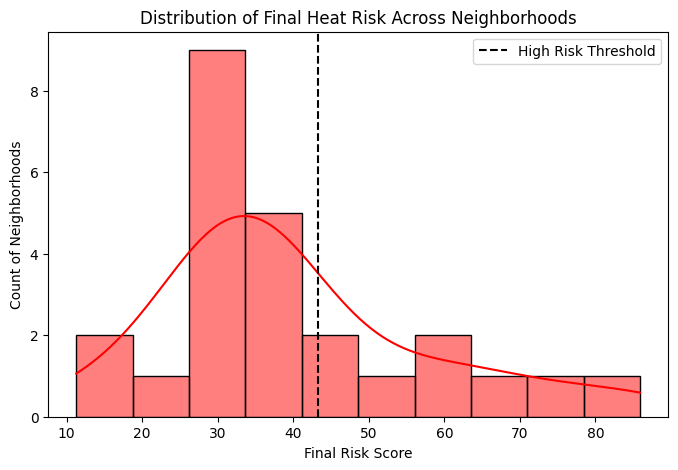

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(gdf["final_risk"], bins=10, kde=True, color="red")
plt.axvline(high_risk_threshold, color="black", linestyle="--", label="High Risk Threshold")
plt.title("Distribution of Final Heat Risk Across Neighborhoods")
plt.xlabel("Final Risk Score")
plt.ylabel("Count of Neighborhoods")
plt.legend()
plt.show()


12. Correlation Analysis

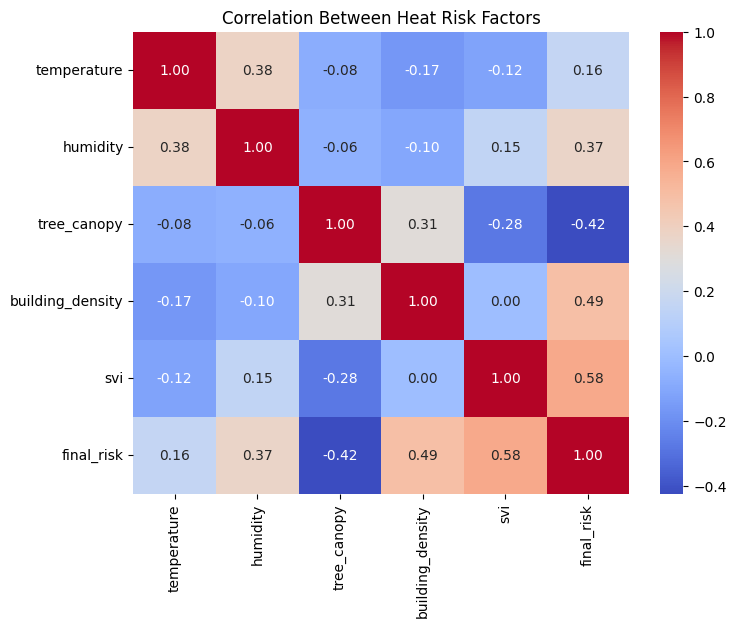

In [ ]:
corr = gdf[["temperature","humidity","tree_canopy","building_density","svi","final_risk"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Heat Risk Factors")
plt.show()

 13. Recommendations Engine

In [ ]:
recommendations = []
for _, row in cooling_deserts.iterrows():
    rec = {
        "neighborhood": row["neighborhood"],
        "action": f"Add new cooling center nearby & increase canopy coverage (Current canopy {row['tree_canopy']:.2f})"
    }
    recommendations.append(rec)

recommendations_df = pd.DataFrame(recommendations)
print("\n✅ Policy Recommendations:")
print(recommendations_df)



✅ Policy Recommendations:
  neighborhood                                             action
0           N4  Add new cooling center nearby & increase canop...
1          N10  Add new cooling center nearby & increase canop...
2          N18  Add new cooling center nearby & increase canop...
3          N20  Add new cooling center nearby & increase canop...


14. Save Outputs

In [ ]:
# Save risk scores and recommendations for reporting
gdf[["neighborhood","final_risk","dist_to_cooling","svi"]].to_csv("heat_risk_results.csv", index=False)
recommendations_df.to_csv("heat_risk_recommendations.csv", index=False)

print("\n📂 Results exported: heat_risk_results.csv & heat_risk_recommendations.csv")


📂 Results exported: heat_risk_results.csv & heat_risk_recommendations.csv
